In [1]:
#!/usr/bin/env python

import numpy as np
import pandas as pd
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
os.environ["PLAIDML_EXPERIMENTAL"] = "1"
os.environ["PLAIDML_DEVICE_IDS"] = "opencl_nvidia_nvidia_geforce_rtx_3060_ti.0"
from keras import backend as K
import random

import keras

import tensorflow as tf
from keras.applications.resnet50 import ResNet50

import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
from keras.models import *
from keras.losses import *
from keras.optimizers import *
from keras.optimizers import Adam
from keras.utils.data_utils import Sequence
from keras.models import Sequential
from keras.utils import to_categorical

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

Using plaidml.keras.backend backend.
C:\Users\ivar_\anaconda3\envs\GPU Tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ivar_\anaconda3\envs\GPU Tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ivar_\anaconda3\envs\GPU Tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\

In [44]:
# Setting paths for training and testing directories
train_dir = r'D:\Datasets FAces\Dataset_Final\Training/' #Set own path
train_paths = []
for label in os.listdir(train_dir):
    for file in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+file)
random.shuffle(train_paths)

test_dir = r'D:\Datasets FAces\Dataset_Final\test_test/' #Set own path
test_paths = []
for label in os.listdir(test_dir):
    for file in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+file)
random.shuffle(test_paths)

# Predict on new data:

predict_dir = r'D:/Datasets FAces/Dataset_Final/test_final/' #Set own path
predict_paths = []
for label in os.listdir(predict_dir):
    for file in os.listdir(predict_dir+label):
        predict_paths.append(predict_dir+label+'/'+file)


In [3]:
labels = os.listdir(train_dir)
labels

['correct_mask', 'incorrect_mask', 'no_mask']

In [4]:
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(128,128))
        input_arr = keras.preprocessing.image.img_to_array(image)
        input_arr = np.array(input_arr)/255.0 # Convert single image to a batch
        images.append(input_arr)
    return np.array(images)

In [5]:
# Extract labels from paths:
def get_labels(paths):
    label = []
    for path in paths:
        path = path.split('/')[-2]
        label.append(labels.index(path))
    return label

In [6]:
test_images = open_images(test_paths)
test_labels = get_labels(test_paths)
test_labels = to_categorical(test_labels)

In [7]:
train_images = open_images(train_paths)
train_labels = get_labels(train_paths)
train_labels = to_categorical(train_labels)
print('loaded')

loaded


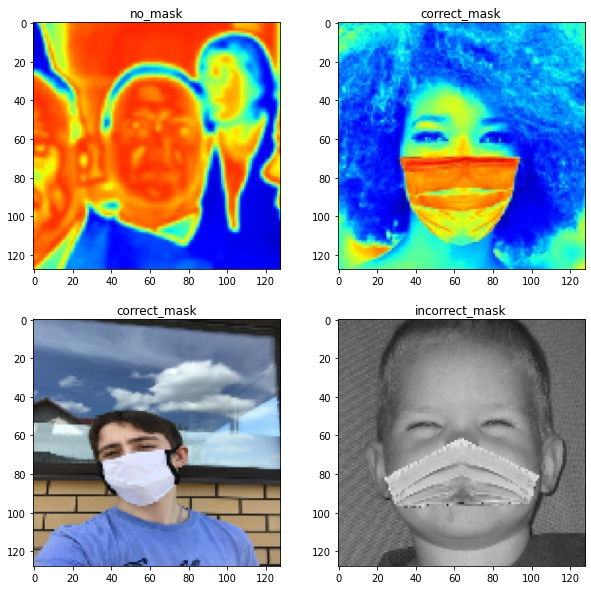

In [8]:
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(train_images[i])
    plt.title(train_paths[i].split('/')[-2]) #Grabs the label from path

plt.show()

In [9]:
# TEST MODEL
#model = Sequential()
#model.add(Conv2D(32, (3, 3),
#                 activation='relu',
#                 input_shape=(128, 128, 3)))
#
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
#
#model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

#model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.4))

#model.add(Flatten())
#model.add(Dense(64))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
#model.add(Dense(3))
#model.add(Activation('softmax'))

#model.compile(loss=keras.losses.categorical_crossentropy,
              #optimizer=keras.optimizers.RMSprop(1e-3),
#              optimizer='adam',
              #optimizer=keras.optimizers.SGD(lr=1e-4, momentum=0.9),
#              metrics=['accuracy'])
#model.summary()

In [10]:
#batch_size=32
batch_size=128
#epochs = 30

In [11]:
#inputs = np.concatenate((train_images, test_images), axis=0)
#targets = np.concatenate((train_labels, test_labels), axis=0)
inputs = train_images
targets = train_labels

In [12]:
# Create the Validation Dataset
Xtrain, Xval, ytrain, yval = train_test_split(inputs, targets, train_size=0.9, test_size=0.1, random_state=42)
Xtrain, Xtest, ytrain, ytest = train_test_split(Xtrain, ytrain, train_size=0.78, random_state=42)

In [13]:
# Increase number of training samples

train_datagen = ImageDataGenerator(horizontal_flip=True, 
                                   vertical_flip=True)
it = train_datagen.flow(Xtrain, ytrain)

In [14]:
# Augment validation set
val_datagen = ImageDataGenerator(horizontal_flip=True, 
                                   vertical_flip=True)
val_it = val_datagen.flow(Xval, yval)

In [15]:
# Augment test set
test_datagen = ImageDataGenerator(horizontal_flip=True, 
                                   vertical_flip=True)
test_it = val_datagen.flow(Xtest, ytest)

In [16]:
import math
steps_per_epoch = math.ceil(len(Xtrain)/32) #Recommended size. 32 is the inital batch size
#steps_per_epoch = 300

In [17]:
#history = model.fit_generator(
#    it, epochs=epochs, verbose=2,
#    callbacks=None, validation_data=(val_it), shuffle=True,
#    class_weight=None,steps_per_epoch=steps_per_epoch,
#    validation_steps=None,
#    max_queue_size=10, workers=1, use_multiprocessing=False)

In [18]:
#score = model.evaluate(test_images, test_labels, verbose=0)
#score = model.evaluate_generator(test_it, verbose=0)
#print("Test loss:", score[0])
#print("Test accuracy:", score[1])

In [19]:
#print("Evaluate on test data")
#results = model.evaluate(test_images, test_labels, batch_size=128)
#print("test loss, test acc:", results)

In [20]:
# Plot accuracy
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'val'], loc='upper left')
#plt.show()

In [21]:
# Plot loss
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('model loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train', 'val'], loc='upper left')
#plt.show()

In [22]:
# Plot MRI and prediction on random sample
#i = random.randint(0,len(test_paths))
#images = open_images([test_paths[i]])
#predicted = model.predict(images)[0]
#predicted = np.argmax(predicted)
#predicted = labels[predicted]
#label = test_paths[i].split('/')[-2]
#plt.imshow(images[0])
#print('Predicted:', predicted)
#print('Actual:', label)

In [23]:
# Apply early stopping to find optimal number of epochs
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",
                                        mode ="min", patience = 10,
                                        restore_best_weights = True)


In [24]:
# Add feature extractors from ResNet50 pretrained network

#restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(128,128,3))
#output = restnet.layers[-1].output
#output = keras.layers.Flatten()(output)
#restnet = Model(restnet.input, output=output)
#for layer in restnet.layers:
#    layer.trainable = False
#restnet.summary()

In [25]:
# Add feature extractors from VGG16/VGG19 pretrained network
#from keras.applications.vgg19 import VGG19
#from keras.models import Model

# load model
#VGG = VGG19(include_top=False, input_shape=(128, 128, 3))

In [26]:
num_folds = 5
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

acc_per_fold = []
loss_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
#for train, test in kfold.split(inputs, targets):
for train, test in kfold.split(it):

    # Define the model architecture
    model = Sequential()
    # ResNet Model
    #model.add(restnet)
    #model.add(Dense(512, activation='relu', input_dim=(128,128,3)))
    #model.add(Dropout(0.3))
    #model.add(Dense(128, activation='relu'))
    #model.add(Dropout(0.3))
    
    # VGG Model
    #model.add(VGG)
    #model.add(Dense(512, activation='relu', input_dim=(128,128,3)))
    #model.add(Dropout(0.3))
    #model.add(Dense(128, activation='relu'))
    #model.add(Dropout(0.3))
    
    # Plain CNN Model as reference
    model.add(Conv2D(32, (3, 3),
                 activation='relu',
                 input_shape=(128,128,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten()) # Uncomment for VGG16, comment for ResNet50
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3))
    model.add(Dense(3, activation='softmax'))
    #model.add(Activation('softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
              #optimizer=optimizers.RMSprop(lr=2e-5),
              optimizer='adam',
              metrics=['accuracy'])


    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model

    history = model.fit_generator(
    it, epochs=300, verbose=2,
    callbacks=[earlystopping], validation_data=(val_it), shuffle=True,
    class_weight=None,steps_per_epoch=steps_per_epoch,
    validation_steps=None,
    max_queue_size=10, workers=1, use_multiprocessing=False)

    # Generate generalization metrics
    scores = model.evaluate_generator(test_it, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

INFO:plaidml:Opening device "opencl_nvidia_nvidia_geforce_rtx_3060_ti.0"


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/300
 - 16s - loss: 1.2286 - acc: 0.3542 - val_loss: 1.0772 - val_acc: 0.4133
Epoch 2/300
 - 2s - loss: 1.0543 - acc: 0.4126 - val_loss: 1.0238 - val_acc: 0.5733
Epoch 3/300
 - 1s - loss: 0.9940 - acc: 0.4830 - val_loss: 0.9662 - val_acc: 0.5267
Epoch 4/300
 - 1s - loss: 0.9228 - acc: 0.5215 - val_loss: 0.8738 - val_acc: 0.5600
Epoch 5/300
 - 1s - loss: 0.8818 - acc: 0.5652 - val_loss: 0.8665 - val_acc: 0.5600
Epoch 6/300
 - 1s - loss: 0.8304 - acc: 0.5942 - val_loss: 0.8092 - val_acc: 0.5867
Epoch 7/300
 - 1s - loss: 0.8147 - acc: 0.6075 - val_loss: 0.7041 - val_acc: 0.7000
Epoch 8/300
 - 1s - loss: 0.7641 - acc: 0.6484 - val_loss: 0.6424 - val_acc: 0.7400
Epoch 9/300
 - 1s - loss: 0.7110 - acc: 0.6887 - val_loss: 0.5751 - val_acc: 0.7667
Epoch 10/300
 - 1s - loss: 0.6663 - acc: 0.6909 - val_loss: 0.5415 - val_acc: 0.7267
Epoch 11/300
 - 1s - loss: 0.6299 - acc: 0.6809 - val_loss: 0

Epoch 31/300
 - 1s - loss: 0.2717 - acc: 0.8934 - val_loss: 0.1371 - val_acc: 0.9667
Epoch 32/300
 - 1s - loss: 0.2605 - acc: 0.8918 - val_loss: 0.1752 - val_acc: 0.9400
Epoch 33/300
 - 1s - loss: 0.2682 - acc: 0.8739 - val_loss: 0.1416 - val_acc: 0.9400
Epoch 34/300
 - 1s - loss: 0.2570 - acc: 0.8992 - val_loss: 0.1602 - val_acc: 0.9400
Epoch 35/300
 - 1s - loss: 0.2649 - acc: 0.8900 - val_loss: 0.1669 - val_acc: 0.9333
Epoch 36/300
 - 1s - loss: 0.2301 - acc: 0.9081 - val_loss: 0.1593 - val_acc: 0.9400
Epoch 37/300
 - 1s - loss: 0.2736 - acc: 0.8861 - val_loss: 0.1728 - val_acc: 0.9467
Epoch 38/300
 - 1s - loss: 0.2458 - acc: 0.8869 - val_loss: 0.1313 - val_acc: 0.9533
Epoch 39/300
 - 1s - loss: 0.2126 - acc: 0.9134 - val_loss: 0.1525 - val_acc: 0.9467
Epoch 40/300
 - 1s - loss: 0.2401 - acc: 0.8977 - val_loss: 0.1483 - val_acc: 0.9267
Epoch 41/300
 - 1s - loss: 0.1881 - acc: 0.9231 - val_loss: 0.1106 - val_acc: 0.9667
Epoch 42/300
 - 1s - loss: 0.1814 - acc: 0.9252 - val_loss: 0.116

Epoch 5/300
 - 1s - loss: 0.7239 - acc: 0.6535 - val_loss: 0.6776 - val_acc: 0.7067
Epoch 6/300
 - 1s - loss: 0.6635 - acc: 0.6792 - val_loss: 0.6127 - val_acc: 0.6667
Epoch 7/300
 - 1s - loss: 0.6934 - acc: 0.6472 - val_loss: 0.5530 - val_acc: 0.7267
Epoch 8/300
 - 1s - loss: 0.5982 - acc: 0.7285 - val_loss: 0.4423 - val_acc: 0.8067
Epoch 9/300
 - 1s - loss: 0.5551 - acc: 0.7348 - val_loss: 0.4853 - val_acc: 0.7800
Epoch 10/300
 - 1s - loss: 0.5045 - acc: 0.7553 - val_loss: 0.4767 - val_acc: 0.7800
Epoch 11/300
 - 1s - loss: 0.5131 - acc: 0.7665 - val_loss: 0.3964 - val_acc: 0.8467
Epoch 12/300
 - 1s - loss: 0.4419 - acc: 0.8053 - val_loss: 0.3361 - val_acc: 0.8533
Epoch 13/300
 - 1s - loss: 0.4707 - acc: 0.7917 - val_loss: 0.3566 - val_acc: 0.8600
Epoch 14/300
 - 1s - loss: 0.4373 - acc: 0.7948 - val_loss: 0.3347 - val_acc: 0.8600
Epoch 15/300
 - 1s - loss: 0.3973 - acc: 0.8202 - val_loss: 0.3416 - val_acc: 0.8800
Epoch 16/300
 - 1s - loss: 0.3957 - acc: 0.8223 - val_loss: 0.3024 - v

Epoch 57/300
 - 1s - loss: 0.2437 - acc: 0.8842 - val_loss: 0.1568 - val_acc: 0.9400
Epoch 58/300
 - 1s - loss: 0.2224 - acc: 0.8986 - val_loss: 0.1386 - val_acc: 0.9400
Epoch 59/300
 - 1s - loss: 0.2262 - acc: 0.8887 - val_loss: 0.1598 - val_acc: 0.9267
Epoch 60/300
 - 1s - loss: 0.2119 - acc: 0.9012 - val_loss: 0.1263 - val_acc: 0.9400
Epoch 61/300
 - 1s - loss: 0.2296 - acc: 0.8899 - val_loss: 0.1609 - val_acc: 0.9400
Epoch 62/300
 - 1s - loss: 0.2392 - acc: 0.8796 - val_loss: 0.1280 - val_acc: 0.9600
Epoch 63/300
 - 1s - loss: 0.2166 - acc: 0.8775 - val_loss: 0.1417 - val_acc: 0.9467
Epoch 64/300
 - 1s - loss: 0.1980 - acc: 0.9015 - val_loss: 0.1206 - val_acc: 0.9467
Epoch 65/300
 - 1s - loss: 0.2056 - acc: 0.9030 - val_loss: 0.1387 - val_acc: 0.9467
Epoch 66/300
 - 1s - loss: 0.1985 - acc: 0.8871 - val_loss: 0.1365 - val_acc: 0.9333
Epoch 67/300
 - 1s - loss: 0.2022 - acc: 0.8964 - val_loss: 0.1092 - val_acc: 0.9533
Epoch 68/300
 - 1s - loss: 0.1802 - acc: 0.9094 - val_loss: 0.127

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 128)       73856     
__________

In [35]:
model.save('Keras CNN Model')

In [28]:
# Print accuracy and loss
score = model.evaluate_generator(test_it, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.12677295041907113
Test accuracy: 0.9562289562289562


In [29]:
y_predicted = []
y_labels = []
for i in range(0,len(test_paths)):
    images = open_images([test_paths[i]])
    predict = model.predict(images)[0]
    predict = np.argmax(predict)
    predict = labels[predict]
    y_predicted.append(predict)
    label = test_paths[i].split('/')[-2]
    y_labels.append(label)

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_labels, y_predicted, target_names=labels))

                precision    recall  f1-score   support

  correct_mask       0.67      1.00      0.80         6
incorrect_mask       0.83      1.00      0.91         5
       no_mask       1.00      0.64      0.78        11

      accuracy                           0.82        22
     macro avg       0.83      0.88      0.83        22
  weighted avg       0.87      0.82      0.81        22



In [31]:
## Create the Confusion Matrix out of the Actual and Predicted Data.
#cm = confusion_matrix(y_labels, y_predicted)
#cmd_obj = ConfusionMatrixDisplay(cm, display_labels=labels)
#cmd_obj.plot()
#cmd_obj.ax_.set(
#                title='Confusion Matrix', 
#                xlabel='Predicted', 
#                ylabel='Actual')
#plt.show()

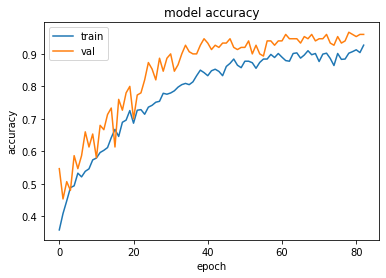

In [32]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

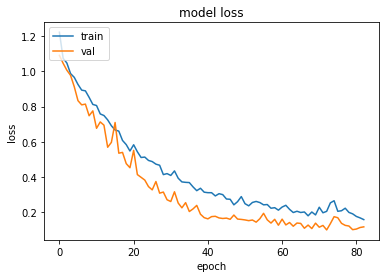

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [45]:
# Predict Facemask
for i in range(0,len(predict_paths)):
    images = open_images([predict_paths[i]])
    predicted = model.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels[predicted]
    label = predict_paths[i].split('/')[-2]
    print(predict_paths[i],'Predicted:', predicted)

D:/Datasets FAces/Dataset_Final/test_final/correct_mask/1.png Predicted: incorrect_mask
D:/Datasets FAces/Dataset_Final/test_final/correct_mask/10.PNG Predicted: correct_mask
D:/Datasets FAces/Dataset_Final/test_final/correct_mask/11.PNG Predicted: incorrect_mask
D:/Datasets FAces/Dataset_Final/test_final/correct_mask/12.PNG Predicted: correct_mask
D:/Datasets FAces/Dataset_Final/test_final/correct_mask/13.PNG Predicted: correct_mask
D:/Datasets FAces/Dataset_Final/test_final/correct_mask/14.PNG Predicted: incorrect_mask
D:/Datasets FAces/Dataset_Final/test_final/correct_mask/15.PNG Predicted: correct_mask
D:/Datasets FAces/Dataset_Final/test_final/correct_mask/16.PNG Predicted: correct_mask
D:/Datasets FAces/Dataset_Final/test_final/correct_mask/2.PNG Predicted: incorrect_mask
D:/Datasets FAces/Dataset_Final/test_final/correct_mask/3.PNG Predicted: incorrect_mask
D:/Datasets FAces/Dataset_Final/test_final/correct_mask/5.PNG Predicted: incorrect_mask
D:/Datasets FAces/Dataset_Final/tes

In [53]:
# Predict Facemask
predict_dir = r'D:/Datasets FAces/test/' #Set own path
predict_paths = []
for label in os.listdir(predict_dir):
    for file in os.listdir(predict_dir+label):
        predict_paths.append(predict_dir+label+'/'+file)

for i in range(0,len(predict_paths)):
    images = open_images([predict_paths[i]])
    predicted = model.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels[predicted]
    label = predict_paths[i].split('/')[-2]
    print(predict_paths[i],'Predicted:', predicted)

D:/Datasets FAces/test/no_mask/4.PNG Predicted: incorrect_mask
D:/Datasets FAces/test/no_mask/t19.PNG Predicted: correct_mask
D:/Datasets FAces/test/no_mask/TD_IR_E_1.jpg Predicted: no_mask
D:/Datasets FAces/test/no_mask/TD_IR_E_2 (1).jpg Predicted: no_mask
D:/Datasets FAces/test/no_mask/TD_IR_E_2.jpg Predicted: no_mask
D:/Datasets FAces/test/no_mask/TD_IR_E_3 (1).jpg Predicted: no_mask
D:/Datasets FAces/test/no_mask/TD_IR_E_3.jpg Predicted: no_mask
D:/Datasets FAces/test/no_mask/TD_IR_E_4 (1).jpg Predicted: no_mask
D:/Datasets FAces/test/no_mask/TD_IR_E_4.jpg Predicted: no_mask
D:/Datasets FAces/test/no_mask/TD_IR_E_5 (1).jpg Predicted: correct_mask
D:/Datasets FAces/test/no_mask/TD_IR_E_5.jpg Predicted: correct_mask
